In [80]:
import pandas as pd

#projects1_1 = pd.read_csv('kickstarter-projects/ks-projects-201612.csv', encoding='latin1')
projects1_2 = pd.read_csv('kickstarter-projects/ks-projects-201801.csv')
projects2 = pd.read_csv('funding-successful-projects-on-kickstarter/train.csv')

In [81]:
pd.__version__

'0.22.0'

In [82]:
# Clean up the column names, which for some reason have spaces after them
projects1_1.columns = [x.strip() for x in projects1_1.columns]

# Get the common columns between the two datasets
overlapping_columns = list(set(projects1_1.columns) & set(projects1_2.columns))

# Join the datasets together
projects1 = projects1_2 # projects1_1[overlapping_columns].append(projects1_2[overlapping_columns])

# Drop duplicates
projects1 = projects1.drop_duplicates('name')

In [83]:
projects = projects1.merge(projects2, on='name', how='inner')
projects = projects.dropna()
projects.columns

Index(['ID', 'name', 'category', 'main_category', 'currency_x', 'deadline_x',
       'goal_x', 'launched', 'pledged', 'state', 'backers', 'country_x',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'project_id',
       'desc', 'goal_y', 'keywords', 'disable_communication', 'country_y',
       'currency_y', 'deadline_y', 'state_changed_at', 'created_at',
       'launched_at', 'backers_count', 'final_status'],
      dtype='object')

In [121]:
renames = {
    'country_x': 'country',
    'currency_x': 'currency',
    'goal_usd_real': 'goal',
    'country_y': 'country',
    'currency_y': 'currency',
    'deadline_y': 'deadline',
    'backers_count': 'backers'
}

to_num = lambda x: pd.to_numeric(x, errors='coerce')
to_date = lambda x: pd.to_datetime(x, unit='s').astype('timedelta64[s]')
conversions = {
    'usd pledged' : to_num,
    'backers': to_num,
    'deadline': to_date,
    'launched_at': to_date,
    'state_changed_at': to_date,
    'created_at': to_date,
    'goal': to_num,
    'pledged': to_num,
}

drops = (
    'ID', 'project_id', 'keywords', 'deadline_x', 'launched', 'disable_communication', 'goal_y'
)

In [122]:
def clean_df(df, renames=None, retypes=None, drops=None):
    if renames is not None:
        for orig, new in renames.items():
            print(orig)
            if new in df.columns:
                diffs = df[[orig, new]][df[orig] != df[new]]
                print(diffs[:10])
                df = df.drop(orig, axis=1)
            else:
                df = df.rename(columns={orig: new})
    print(df.columns)
    if retypes is not None:
        for col, conv in retypes.items():
            dfcol = df[col]
            df = df.drop(col, axis=1)
            df[col] = conv(dfcol)
    if drops is not None:
        for col in drops:
            df = df.drop(col, axis=1)
            
    df = df.dropna(axis=1, how='all')
    df = df.dropna(axis=0, how='any')
    return df
            
cleaned = clean_df(projects, renames, conversions, drops)   

country_x
currency_x
goal_usd_real
country_y
     country_y country
108         US      GB
326         US      CA
383         CA      US
1149        US      CA
1287        US      GB
1539        US      ES
1776        GB      US
1910        CA      US
1997        US      CA
2053        AU      US
currency_y
     currency_y currency
108         USD      GBP
326         USD      CAD
383         CAD      USD
1149        USD      CAD
1287        USD      GBP
1539        USD      EUR
1776        GBP      USD
1910        CAD      USD
1997        USD      CAD
2053        AUD      USD
deadline_y
backers_count
     backers_count  backers
58             142        7
108             12        2
132             67        0
133              3        0
187             71       14
234             17        2
326             15       22
334             44        2
367             35      171
383              0       63
Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline_x',
       

TypeError: cannot astype a datetimelike from [datetime64[ns]] to [timedelta64[s]]

In [123]:
from scipy import stats

cleaned['desc_len'] = cleaned.desc.str.len()
cleaned['duration'] = cleaned['deadline'] - cleaned['created_at']

In [124]:
cleaned['scaled_created_at'] = cleaned.created_at * (max(cleaned.created_at) - min(cleaned.created_at)) + min(cleaned.created_at)
cleaned


,name,category,main_category,currency,state,country,usd_pledged_real,usd_goal_real,desc,final_status,...,backers,deadline,launched_at,state_changed_at,created_at,goal,pledged,desc_len,duration,scaled_created_at
0,Where is Hank?,Narrative Film,Film & Video,USD,failed,US,220.00,45000.00,"Abandoned Property. Sounds of struggle, muffle...",0,...,3,1361834450000000000,1357946450000000000,1361834450000000000,1357603284000000000,45000.0,220.00,106,4231166000000000,-5116509716060944896
1,Of Jesus and Madmen,Nonfiction,Publishing,CAD,failed,CA,0.00,2406.39,This is an autobiography of my personal experi...,0,...,0,1381335577000000000,1378743577000000000,1381335577000000000,1378130153000000000,2500.0,0.00,124,3205424000000000,5528525002614130176
2,The Beard,Comic Books,Comics,USD,failed,US,395.00,1500.00,'The beard' is a comedy based comic about an a...,0,...,16,1415482072000000000,1412886472000000000,1415482072000000000,1412172842000000000,1500.0,395.00,129,3309230000000000,215854041412027904
3,Notes From London: Above & Below,Art Books,Publishing,USD,failed,US,789.00,3000.00,Notes From London: Above & Below is an unusual...,0,...,20,1431285654000000000,1428693654000000000,1431285655000000000,1428526605000000000,3000.0,789.00,132,2759049000000000,-6118407297032108544
4,Mountain brew: A quest for alcohol sustainability,Drinks,Food,NOK,failed,NO,6.29,65.55,This is the start of an exiting venture of bre...,0,...,3,1424888253000000000,1422296253000000000,1424888253000000000,1422045831000000000,500.0,48.00,113,2842422000000000,-9135750655352879616
5,Permaculture Skills,Webseries,Film & Video,CAD,successful,CA,42174.03,15313.04,A film series distilled from 20 days of cold-c...,1,...,571,1418576520000000000,1415984520000000000,1418576521000000000,1407959136000000000,17757.0,48905.00,102,10617384000000000,-2806318280727706112
6,Daily Brew Coffee,Food Trucks,Food,GBP,failed,GB,31.09,5181.12,Daily Brew an artisan cafe based in a Piaggio ...,0,...,1,1427817992000000000,1425229592000000000,1427817994000000000,1425208254000000000,3500.0,21.00,121,2609738000000000,5945773103211759104
7,BB130A,Public Art,Art,USD,failed,US,1395.00,25000.00,This monumental event will exhibit how people ...,0,...,30,1364080048000000000,1360627648000000000,1364080048000000000,1360376872000000000,25000.0,1395.00,132,3703176000000000,1529602645384906240
8,Arrows & Sound Debut Album,Indie Rock,Music,USD,successful,US,8641.34,4000.00,"Philip Zach, formerly of Remedy Drive, is reco...",1,...,157,1337382271000000000,1334790271000000000,1337382271000000000,1328116784000000000,4000.0,8641.34,122,9265487000000000,2922310409971713536
9,Help Scott Reynolds Make a New Record!,Indie Rock,Music,USD,successful,US,17499.99,15000.00,It's been 4 years since his last release. He's...,1,...,277,1346604196000000000,1344012196000000000,1346604197000000000,1334611356000000000,15000.0,17499.99,134,11992840000000000,-1728832232736799232


In [222]:
import numpy as np
import matplotlib.pyplot as plt

def summarize(df):
    n_failed = np.count_nonzero(df.state == 'failed')
    print("{} Failed".format(n_failed))
    n_success = np.count_nonzero(df.state == 'successful')
    print("{} Success".format(n_success))
    
def hist_by_group(df, groupname, n_groups=None):
    if n_groups is None:
        grouped = df.groupby(groupname)
        names = grouped.groups.keys()
    else:
        pcts = np.arange(0, 1, 1/float(n_groups))
        quantiles = df[groupname].quantile(pcts)
        inds = np.digitize(df[groupname], quantiles)
        grouped = df.groupby(inds)
        names = []
        for a, b in zip(pcts, pcts[1:]):
            names.append('{}-{}'.format(quantiles[a], quantiles[b]))
        names.append('{}-{}'.format(quantiles[b], max(df[groupname])))
    
    num_groups = len(grouped)
    
    successes = []
    failures = []

    margins = []
    totals = []
    
    for name, group in grouped:

        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        successes.append(float(n_success) / len(group))
        failures.append(float(n_failed) / len(group))
        
        margins.append(np.abs(n_success - n_failed))
        totals.append(n_success + n_failed)
    
    
    
    bar_width = .25
    indices = np.arange(num_groups)
    
    plt.bar(indices, successes, bar_width, color='g', label='succes')
    plt.bar(indices + bar_width, failures, bar_width, color='r', label='failures')
    plt.xticks(indices + bar_width * 1.5, names)
    plt.gca().set_ylabel("Percentage")
    plt.gca().set_xlabel(groupname)
    plt.legend()
    
def rolling_success(df):
    
    statuses = df[(df['state'] == 'failed') | (df['state'] == 'successful')]
    
    statuses['succeeded'] = statuses['state'] == 'successful'
    
    grouped = statuses.groupby((statuses['goal'] / 1000).astype(int))

    not_alone = grouped.size() > 10
    
    success_rate = grouped['succeeded'].mean()[not_alone]
    
    ax = plt.subplot()
    print(success_rate.shape)
    plt.plot(success_rate.index, success_rate, '.')
    ax.set_xscale('log')
    ax.set_xlabel("Goal")
    ax.set_ylabel("Success Ratio")

def success_over_time(df, col):
    quantiles = df['created_at'].quantile(np.arange(0, 1, .1))
    inds = np.digitize(df['created_at'], quantiles)
    grouped = df.groupby(inds)
    
    unique_cols = df[col].unique()
    
    dates = []
    data = []
    names = []
    for unique_col in unique_cols:
        col_data = []
        for _, group in grouped:
            group = group[group[col] == unique_col]
            n_failed = np.count_nonzero(group.state == 'failed')
            n_success = np.count_nonzero(group.state == 'successful')
            col_data.append(n_success / len(group))
        data.append(col_data)
        names.append(unique_col)

    all_data = []
    for _, group in grouped:
        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        all_data.append(n_success / len(group))

        
    for q in quantiles:
        dates.append(np.datetime64(int(q), 's'))
        
    fig, ax = plt.subplots()
    for dat in data:
        ax.plot(dates, dat)
    
    ax.plot(dates, all_data, 'k', linewidth=3)
    
    plt.legend(names + ['All'])
    plt.show()
        
    

<IPython.core.display.Javascript object>


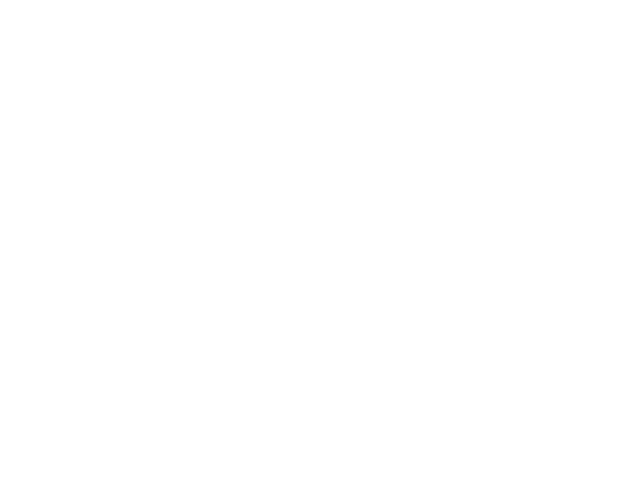

In [223]:
%matplotlib notebook
success_over_time(cleaned, 'main_category')

50979 Failed
43704 Success


<IPython.core.display.Javascript object>


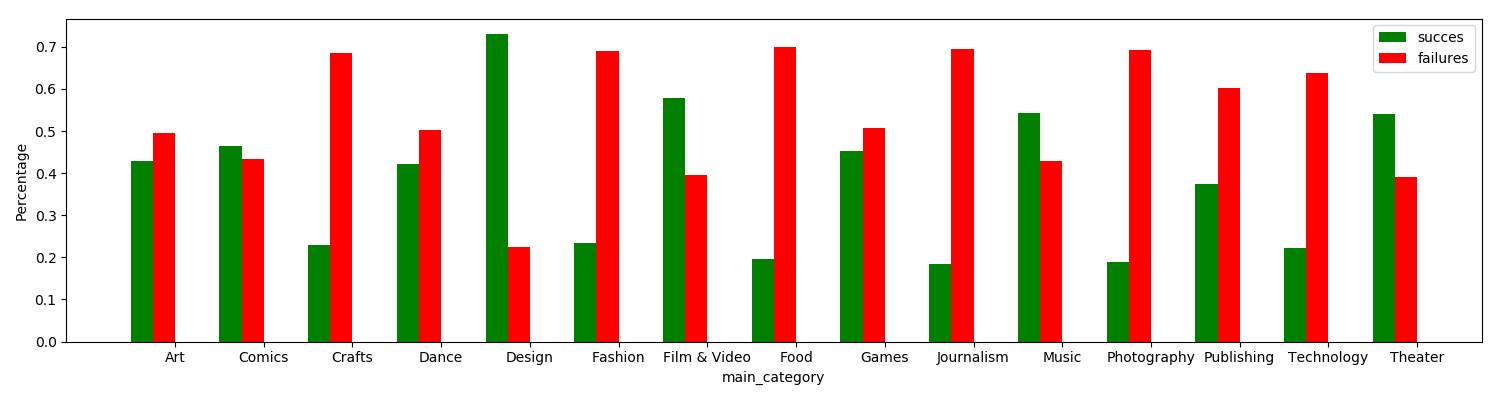

<IPython.core.display.Javascript object>


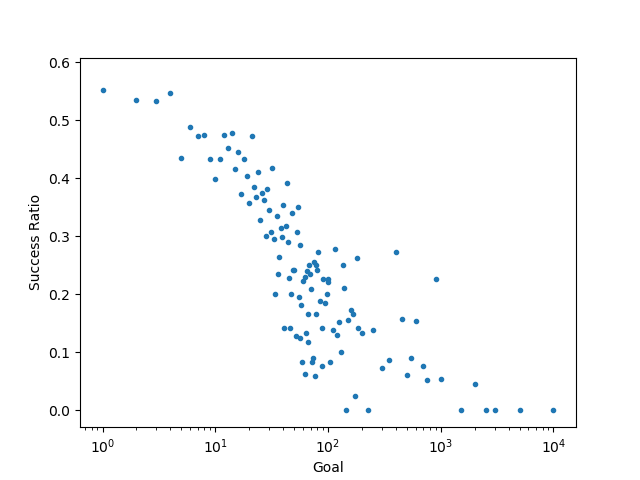

(120,)


/Users/iped/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


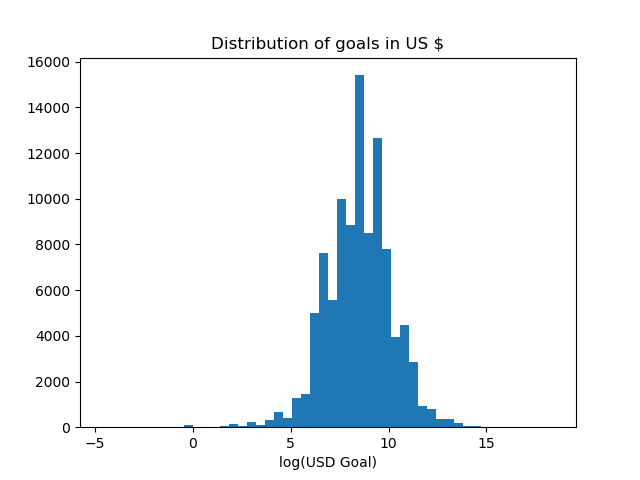

Text(0.5,1,'Distribution of goals in US $')

In [238]:
%matplotlib notebook

summarize(cleaned)
plt.figure(figsize=(15, 4))
hist_by_group(cleaned, 'main_category')
plt.tight_layout()

plt.figure()
rolling_success(cleaned)

fig, ax = plt.subplots()
ax.hist(np.log(cleaned['usd_goal_real']), 50)
plt.show()
plt.xlabel("log(USD Goal)")
plt.title("Distribution of goals in US $")


In [215]:
def goal_percent_comparison(successes, failures):
    ax = plt.subplot()
    plt.plot(successes.goal, successes.pledged/successes.goal, 'g.', alpha=.2)
    plt.plot(failures.goal, failures.pledged/failures.goal, 'r.', alpha=.2)
    ax.set_xscale('log')
    ax.set_xlabel('Goal')
    ax.set_ylabel('% Of Goal Reached')
    plt.ylim([0, 2])
    plt.legend(['successes','failures'])

<IPython.core.display.Javascript object>


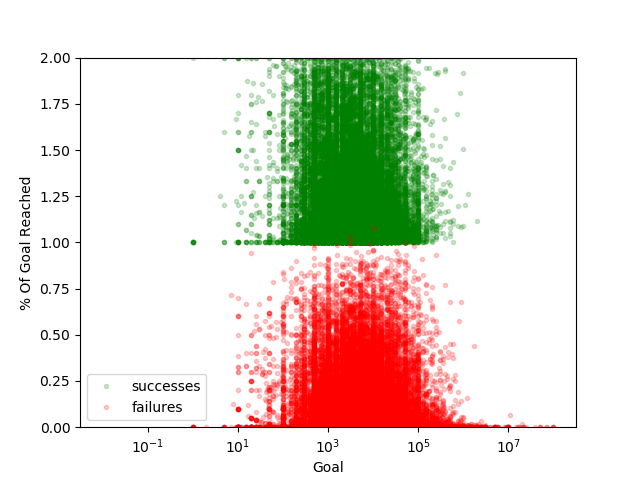

<IPython.core.display.Javascript object>


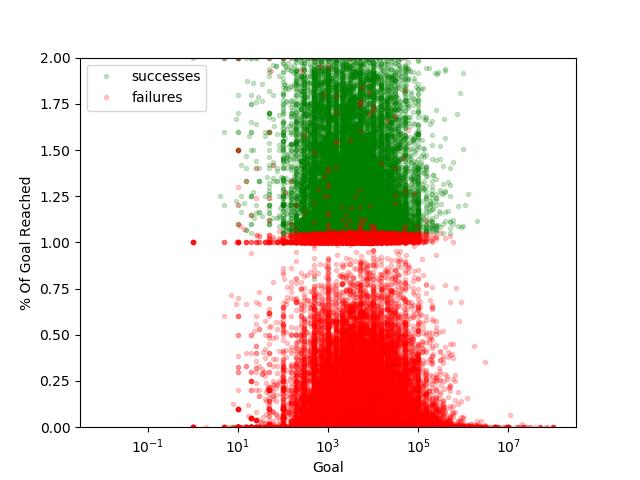

In [216]:
%matplotlib notebook
import matplotlib.pyplot as plt

successes = cleaned[cleaned.state == 'successful']
failures = cleaned[cleaned.state == 'failed']

goal_percent_comparison(successes,failures)

plt.figure()

successes = cleaned[cleaned.final_status == 1]
failures = cleaned[cleaned.final_status == 0]

goal_percent_comparison(successes,failures)


In [52]:
cleaned.columns

Index(['name', 'category', 'main_category', 'currency', 'state', 'country',
       'usd_pledged_real', 'usd_goal_real', 'desc', 'final_status',
       'usd pledged', 'backers', 'deadline', 'launched_at', 'state_changed_at',
       'created_at', 'goal', 'pledged', 'desc_len', 'duration',
       'scaled_created_at'],
      dtype='object')

In [217]:
from sklearn.feature_extraction import DictVectorizer

def create_feature_matrix(df,
                          scalars=None,
                          percentiles = None,
                          groups=None,
                          categoricals=None,
                          splits=None,
                          lengths=None):
    # Should be done using apply or map or something like that
    ds = []
    Y = []
    grps = {}
    
    sorted_pcts = {}
    if percentiles:
        for pct in percentiles:
            sorted_pcts[pct] = np.array(sorted(df[pct]))
    
    if groups:
        for col, grp in groups.items():
            grps[col] = df[col].quantile(np.arange(0, 1, 1.0/grp))
    for _, r in df.iterrows():
        d = {}
        if percentiles is not None:
            for pct in percentiles:
                d[pct] = float(np.argmax(sorted_pcts[pct] > r[pct])) / len(sorted_pcts[pct])
        if groups is not None:
            for grp in groups:
                group = np.nonzero(grps[grp] <= r[grp])[0][-1]
                p = int(100.0 * group / len(grps[grp]))
                d[grp + str(p)] = 1
        if scalars is not None:
            for sca in scalars:
                try:
                    d[sca] = pd.to_numeric(r[sca])
                except:
                    print(d[sca])
                    continue
                        
        if categoricals is not None:
            for cat in categoricals:
                d[cat + r[cat]] = 1
        if splits is not None:
            for spl in splits:
                d.update({(spl+'-'+word): 1 for word in r[spl].split()})
                
        if lengths is not None:
            for lng in lengths:
                d.update({('len-' + lng): len(r[lng])})
        ds.append(d)
    
    
    v = DictVectorizer()
    print("Vectorizing")
    X = v.fit_transform(ds)
    return X.astype(float), v.get_feature_names()


In [70]:
goal_scalar_features, goal_scalar_feature_names = create_feature_matrix(cleaned,
    scalars = ('goal',)
)

Vectorizing


In [31]:
goal_pct_features, goal_pct_feature_names = create_feature_matrix(cleaned,
    percentiles = ('goal',)
)

Vectorizing


In [32]:
goal_group_features, goal_group_feature_names = create_feature_matrix(cleaned,
    groups={'goal': 5}
)

Vectorizing


In [218]:
all_features, all_feature_names = create_feature_matrix(cleaned,
    percentiles = ('goal', 'created_at'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)
all_features_no_date, all_feature_no_date_names = create_feature_matrix(cleaned,
    percentiles = ('goal',),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',)
)

Vectorizing
Vectorizing


In [29]:
string_features, string_feature_names = create_feature_matrix(cleaned,
    categoricals = ('category','main_category', 'country'),
    splits = ('desc', 'name')
)

Vectorizing


In [72]:
all_features_w_len, all_feature_names_w_len = create_feature_matrix(cleaned,
    percentiles = ('goal', 'created_at', 'desc_len', 'duration'),
    categoricals = ('category', 'main_category', 'country',),
    splits = ('desc', 'name',),
)

Vectorizing


In [73]:
import numpy as np
import sklearn
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score

def run_classifier(X, Y, clf, n_folds=5):
    kf = KFold(n_splits=n_folds)
    
    p_corrects = []
    for train, test in kf.split(X):
        x_train = X[train]
        x_test = X[test]
        
        y_train = Y[train]
        y_test = Y[test]
        
        clf.fit(x_train, y_train)
        
        predY = clf.predict(x_test)
    
        p_corrects.append(np.count_nonzero(predY == y_test) / float(len(y_test)))
        print('\tFold accuracy: {:.3f}'.format(p_corrects[-1]))
        
    print("Mean correct across {} folds: {:.3f}".format(n_folds, np.mean(p_corrects)))


def run_classifier_2(X, Y, clf, n_folds=5):
    scores = cross_val_score(clf, X, Y, cv=n_folds)
    print("Mean correct across {} folds: {:.3f} +/- {:.3f}".format(n_folds, scores.mean(), scores.std()))
    
Y = (cleaned.state == 'successful').values

print("Baseline accuracy is {:.3f}".format( 1 - (float(sum(Y)) / len(Y))))

Baseline accuracy is 0.564


In [112]:
run_classifier(goal_scalar_features, Y, LinearSVC())

Mean correct across 5 folds: 0.573426248222


In [113]:
run_classifier(goal_pct_features, Y, LinearSVC())

Mean correct across 5 folds: 0.58637322619


In [27]:
import time
start = time.time()
run_classifier_2(all_features, Y, LinearSVC())
mid = time.time()
run_classifier(all_features, Y, LinearSVC())
end = time.time()

print("T1: {}".format(mid-start))
print("T2: {}".format(end-mid))

Mean correct across 5 folds: 0.726 +/- 0.003
	Fold accuracy: 0.722
	Fold accuracy: 0.728
	Fold accuracy: 0.725
	Fold accuracy: 0.722
	Fold accuracy: 0.730
Mean correct across 5 folds: 0.726
T1: 75.78528785705566
T2: 76.2191231250763


In [74]:
run_classifier(all_features_w_len, Y, LinearSVC())

	Fold accuracy: 0.722
	Fold accuracy: 0.729
	Fold accuracy: 0.727
	Fold accuracy: 0.724
	Fold accuracy: 0.731
Mean correct across 5 folds: 0.727


In [86]:
run_classifier(all_features, Y, LinearSVC())
run_classifier(all_features_no_date, Y, LinearSVC())

	Fold accuracy: 0.721
	Fold accuracy: 0.729
	Fold accuracy: 0.725
	Fold accuracy: 0.722
	Fold accuracy: 0.730
Mean correct across 5 folds: 0.725
	Fold accuracy: 0.722
	Fold accuracy: 0.728
	Fold accuracy: 0.725
	Fold accuracy: 0.722
	Fold accuracy: 0.730
Mean correct across 5 folds: 0.726


In [79]:
run_classifier(all_features_w_len, Y, RandomForestClassifier(n_estimators=30))

KeyboardInterrupt: 

In [76]:
run_classifier(all_features_w_len, Y, DecisionTreeClassifier(max_depth=3))

	Fold accuracy: 0.634
	Fold accuracy: 0.646


KeyboardInterrupt: 

In [132]:
run_classifier(all_features, Y, DecisionTreeClassifier(max_depth=8))

	Fold accuracy: 0.712
	Fold accuracy: 0.722
	Fold accuracy: 0.717
	Fold accuracy: 0.712
	Fold accuracy: 0.712
Mean correct across 5 folds: 0.715


In [19]:

dtree = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=10)
dtree.fit(string_features, Y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [107]:
clf = LinearSVC()
clf.fit(all_features, Y)
pred = clf.predict(all_features)


<IPython.core.display.Javascript object>


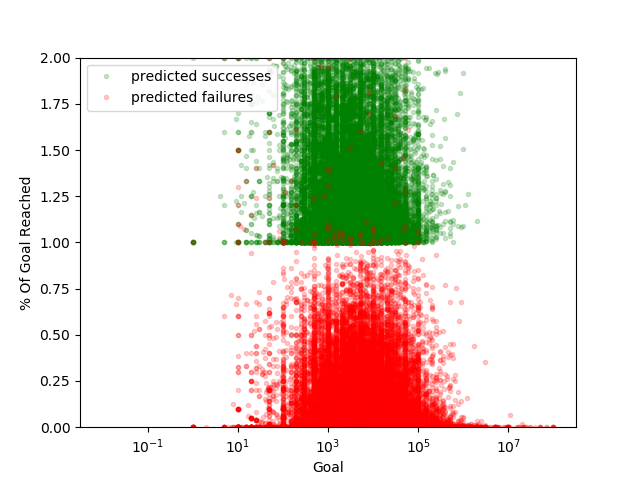

<IPython.core.display.Javascript object>


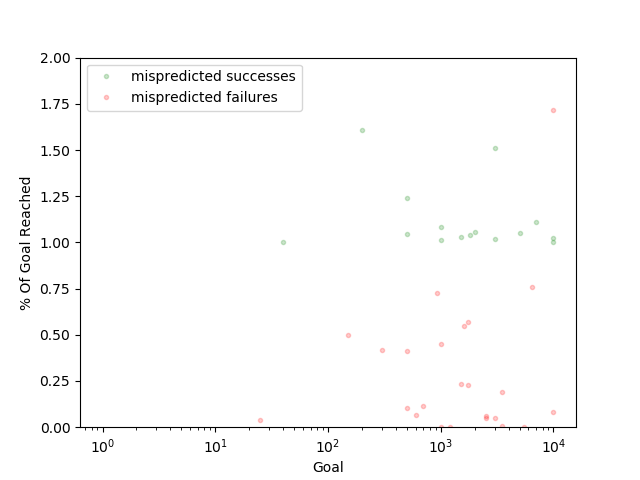

In [108]:
plt.figure()

pred_success = cleaned[pred == 1]
pred_failures = cleaned[pred == 0]
goal_percent_comparison(pred_success, pred_failures)
plt.legend(['predicted successes', 'predicted failures'])

mispred_success = cleaned[(pred == 0) & (cleaned.state == 'successful') ]
mispred_fail = cleaned[(pred == 1) & (cleaned.state != 'successful') ]
plt.figure()
goal_percent_comparison(mispred_success, mispred_fail)
plt.legend(['mispredicted successes', 'mispredicted failures'])

In [31]:
from sklearn.tree import export_graphviz
from graphviz import Source

dot =export_graphviz(dtree, out_file=None, feature_names = string_feature_names, class_names=('failure', 'success'))
Source(dot)

NameError: name 'dtree' is not defined

<IPython.core.display.Javascript object>


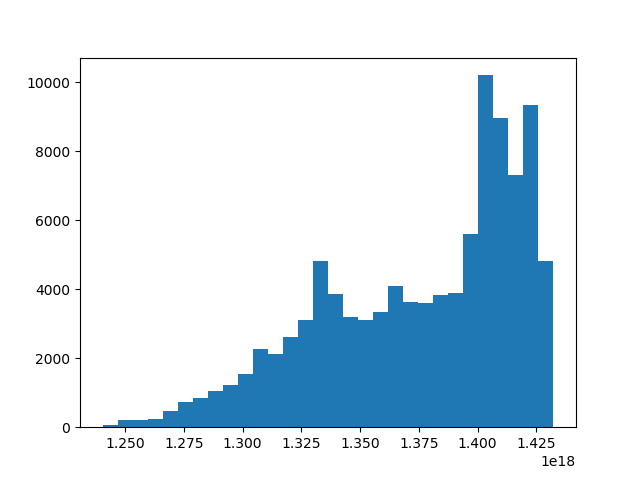

1240335335000000000
1432325200000000000


In [88]:
%matplotlib notebook
plt.hist(cleaned.created_at, 30)
plt.show()
print(cleaned.created_at.min())
print(cleaned.created_at.max())